In [ ]:
!pip install xgboost imbalanced-learn seaborn tensorflow


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, Input


In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("EEG.machinelearing_data_BRMH.csv")  # adjust name if different


Saving EEG.machinelearing_data_BRMH.csv to EEG.machinelearing_data_BRMH (2).csv


In [ ]:
# Encode object columns
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Target encoding
target_encoder = LabelEncoder()
df['target'] = target_encoder.fit_transform(df['main.disorder'].astype(str))
df = df.drop(columns=['main.disorder', 'specific.disorder'], errors='ignore')

# Fill NaNs, remove constant columns
df = df.fillna(df.mean(numeric_only=True))
df = df.loc[:, df.nunique() > 1]


In [ ]:
X = df.drop(columns=['target'])
y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance using SMOTE
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

print("✅ Data balanced:", X_bal.shape)


✅ Data balanced: (1218, 1146)


In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    deep_features, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    objective='multi:softprob',
    num_class=len(np.unique(y_bal))
)

xgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:34:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=7, num_parallel_tree=None, ...)

In [ ]:
# Reshape: (samples, timesteps, features=1)
X_seq = X_bal.reshape((X_bal.shape[0], X_bal.shape[1], 1))

model = Sequential([
    Input(shape=(X_seq.shape[1], 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_bal)), activation='softmax')  # temporary for training
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN+LSTM
history = model.fit(X_seq, y_bal, epochs=50, batch_size=8 , validation_split=0.2)


Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.1994 - loss: 1.9102 - val_accuracy: 0.0205 - val_loss: 2.1572
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.2967 - loss: 1.8108 - val_accuracy: 0.0123 - val_loss: 2.2708
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4037 - loss: 1.6094 - val_accuracy: 0.0451 - val_loss: 2.5377
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4317 - loss: 1.4422 - val_accuracy: 0.1721 - val_loss: 2.0160
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.5567 - loss: 1.2471 - val_accuracy: 0.2951 - val_loss: 1.6978
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5370 - loss: 1.1777 - val_accuracy: 0.2951 - val_loss: 1.8383
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5828 - loss: 1.0466 - val_accuracy: 0.2418 - val_loss: 1.7782
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6320 - loss: 0.9913 - val_accu

In [ ]:
# Remove softmax layer to use dense(128) output as features
feature_model = Sequential(model.layers[:-1])  # till last dense(128)

deep_features = feature_model.predict(X_seq)
print("✅ Deep features shape:", deep_features.shape)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
✅ Deep features shape: (1218, 128)


📈 Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        34
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00        35
           3       0.94      0.91      0.93        35
           4       0.94      0.94      0.94        35
           5       1.00      0.94      0.97        35
           6       0.94      0.97      0.96        35

    accuracy                           0.96       244
   macro avg       0.96      0.96      0.96       244
weighted avg       0.96      0.96      0.96       244



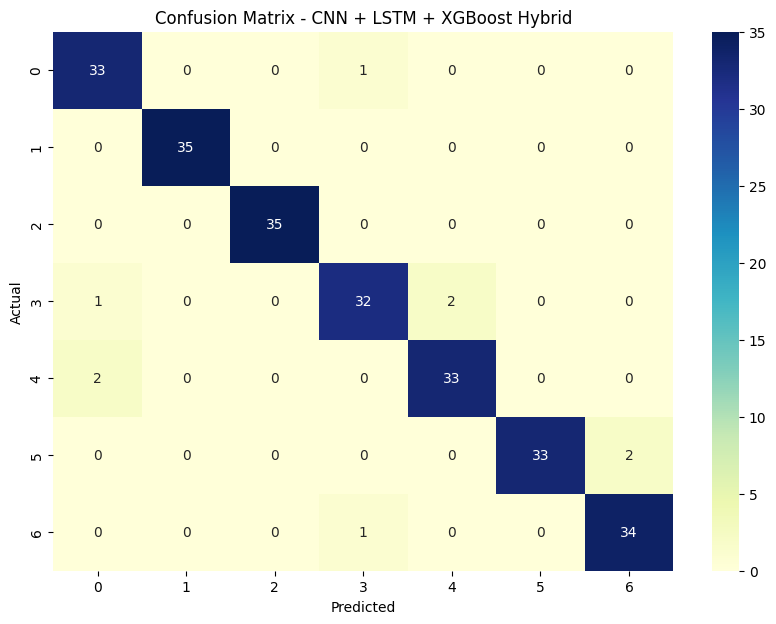

In [ ]:
y_pred = xgb.predict(X_test)

print("📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cmap='YlGnBu')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN + LSTM + XGBoost Hybrid")
plt.show()


In [ ]:
# Reassign your final trained model
final_model = xgb


In [ ]:
import pandas as pd

# Extract feature importance from XGBoost model
importance = final_model.get_booster().get_score(importance_type='weight')

# Convert to DataFrame
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

# Sort by importance descending
importance_df = importance_df.sort_values(by='importance', ascending=False)


In [ ]:
# Select top-k features (k = 150)
top_k = 150  # Change this if needed

top_features = importance_df['feature'].head(top_k).tolist()

print("✅ Top features rebuilt successfully!")
print(top_features[:10])  # Check top 10 features


✅ Top features rebuilt successfully!
['f47', 'f62', 'f85', 'f13', 'f125', 'f46', 'f100', 'f90', 'f112', 'f115']


In [ ]:
import joblib
joblib.dump(top_features, 'top_features.pkl')


['top_features.pkl']

In [ ]:
joblib.dump(final_model, 'final_model.pkl')


['final_model.pkl']

In [ ]:
# Save the trained feature extractor model
feature_model.save('feature_extractor_model.h5')

print("✅ Feature extractor model saved successfully!")


✅ Feature extractor model saved successfully!
